# EDA

In [1]:
from dataset import CustomNPZDataset, HFDataset, SSLDataset
from dataset import get_medmnist_transforms, plot_views, plot_ssl_views


import numpy as np

## Making sure dataset.py functions work

In [2]:
data_path = '../data/pneumoniamnist_224.npz'
size = 224

In [3]:
# For SSL

# Note: For SSL, we pass None as transform to base dataset because
# SSLDataset wrapper handles the transforms (generating 2 views).
# For Supervised, we pass the transform directly.
train_base = CustomNPZDataset(data_path, split='train', transform=None)
val_base = CustomNPZDataset(data_path, split='val', transform=None)
test_base = CustomNPZDataset(data_path, split='test', transform=None)

# Wrap with SSL dataset
transform = get_medmnist_transforms(size=size, augment=True)

train_set = SSLDataset(train_base, transform)
val_set = SSLDataset(val_base, transform)  # Usually SSL is only trained on train_set
test_set = SSLDataset(test_base, transform)

train_set = HFDataset(train_set, for_ssl=True)
val_set = HFDataset(val_set, for_ssl=True)
test_set = HFDataset(test_set, for_ssl=True)

print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")
# print(f"Shapes: {train_set[0]['view1'].shape}, {train_set[0]['view2'].shape}")

Train: 4708, Val: 524, Test: 624


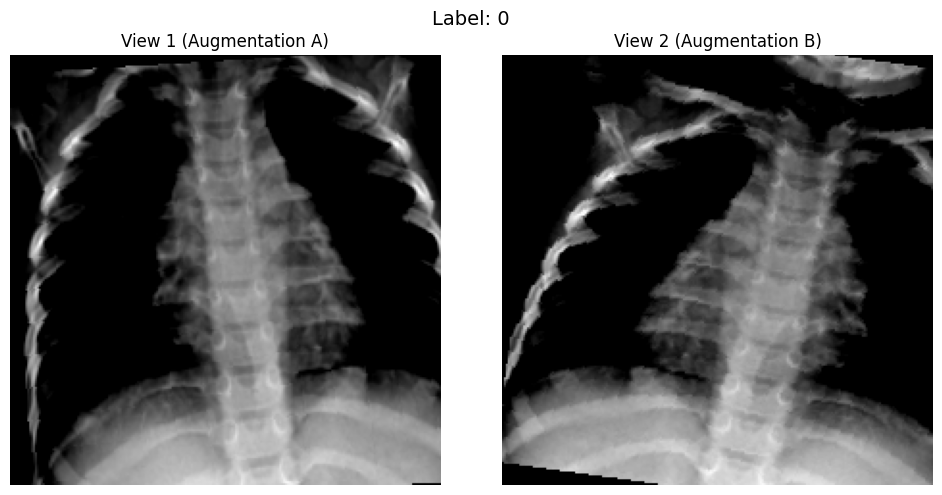

In [4]:
plot_ssl_views(train_set[np.random.randint(0, len(train_set))])

In [5]:
# For SFT
transform = get_medmnist_transforms(size=size, augment=False)

train_base = CustomNPZDataset(data_path, split='train', transform=transform)
val_base = CustomNPZDataset(data_path, split='val', transform=transform)
test_base = CustomNPZDataset(data_path, split='test', transform=transform)

train_set = HFDataset(train_base, for_ssl=False)
val_set = HFDataset(val_base, for_ssl=False)
test_set = HFDataset(test_base, for_ssl=False)

print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")


Train: 4708, Val: 524, Test: 624


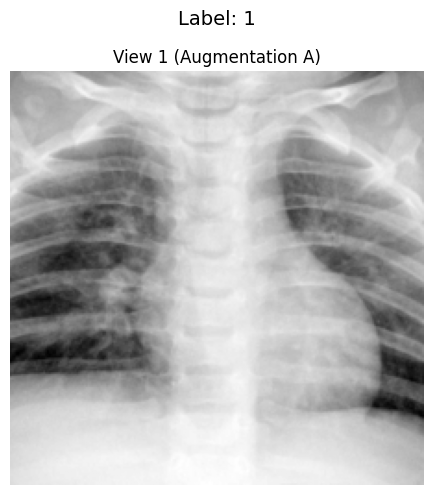

In [6]:
plot_views(train_set[np.random.randint(0, len(train_set))])

## pneumoniamnist

In [7]:
data_path = '../data/pneumoniamnist_224.npz'
size = 224

In [8]:
transform = get_medmnist_transforms(size=size, augment=False)

train_base = CustomNPZDataset(data_path, split='train', transform=transform)
val_base = CustomNPZDataset(data_path, split='val', transform=transform)
test_base = CustomNPZDataset(data_path, split='test', transform=transform)

train_set = HFDataset(train_base, for_ssl=False)
val_set = HFDataset(val_base, for_ssl=False)
test_set = HFDataset(test_base, for_ssl=False)

print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")

Train: 4708, Val: 524, Test: 624


In [9]:
data = np.load('../data/pneumoniamnist_224.npz')
all_images = np.concatenate([data['train_images'], data['val_images'], data['test_images']])

print(f"Dataset size: {all_images.shape}")
print(f"Mean: {all_images.mean() / 255.0:.4f}") # Если данные 0-255
print(f"STD: {all_images.std() / 255.0:.4f}")
u = np.unique(np.concatenate([data['train_labels'], data['val_labels'], data['test_labels']]), return_counts=True)
neg, pos = u[1]
print(f"Class balance:\n\tneg: {neg:,}\n\tpos: {pos:,}")

Dataset size: (5856, 224, 224)
Mean: 0.5706
STD: 0.1773
Class balance:
	neg: 1,583
	pos: 4,273


In [10]:
u

(array([0, 1], dtype=uint8), array([1583, 4273]))

## chestmnist

In [11]:
import numpy as np
from tqdm import tqdm

# This is written by Gemini 3, because my previous code was failing with:
# MemoryError: Unable to allocate 41.9 GiB for an array with shape (112120, 224, 224) and data type float64

def compute_stats_streaming(data_array, batch_size=256):
    """
    Вычисляет Mean и Std для большого массива, обрабатывая его батчами.
    Args:
        data_array: np.array или np.memmap формы (N, H, W) или (N, H, W, C)
    """
    mean = 0.0
    mean_sq = 0.0
    count = 0
    
    # Приводим к (N, -1), чтобы считать по всем пикселям сразу (если нужна статистика по каналам)
    # Или (N, H*W) если данные grayscale.
    # Если data_array в памяти, это просто view.
    
    num_samples = data_array.shape[0]
    
    for i in tqdm(range(0, num_samples, batch_size), desc="Computing stats"):
        # Берём батч
        batch = data_array[i : i + batch_size].astype(np.float32) / 255.0
        
        # Разворачиваем: (B, H, W) -> (B, H*W)
        batch_flat = batch.reshape(batch.shape[0], -1)
        
        # Накапливаем сумму и сумму квадратов
        # Важно взвешивать на размер батча, так как последний батч может быть меньше
        current_batch_size = batch_flat.size # общее число пикселей в батче
        
        mean += batch_flat.sum()
        mean_sq += (batch_flat ** 2).sum()
        count += current_batch_size

    total_mean = mean / count
    total_var = (mean_sq / count) - (total_mean ** 2)
    total_std = np.sqrt(total_var)
    
    return total_mean, total_std

In [12]:
data = np.load('../data/chestmnist_224.npz')
all_images = np.concatenate([data['train_images'], data['val_images'], data['test_images']])

In [13]:
print(f"Dataset size: {all_images.shape}")
mean, std = compute_stats_streaming(all_images)

print(f"Mean: {mean:.4f}")
print(f"STD: {std:.4f}")

Dataset size: (112120, 224, 224)


Computing stats: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 438/438 [00:14<00:00, 30.89it/s]

Mean: 0.4981
STD: 0.2481


In [14]:
u = np.unique(np.concatenate([data['train_labels'], data['val_labels'], data['test_labels']]), return_counts=True)
neg, pos = u[1]
# print(f"Class balance: {u}")
print(f"Class balance:\n\tneg: {neg:,}\n\tpos: {pos:,}")

Class balance:
	neg: 1,488,692
	pos: 80,988


### Результаты

Для chestmnist у нас явно задача несбаллансированной классификации в обоих случаях. В качестве лосса просто возьмем BCE и навесим на меньший класс class weight множитель. В качестве метрики в обоих случаях возьмем PR-AUC. Также можно будет дополнительно померять F-beta score для какого-то порога, так как мы работаем с медицинскими данными, хотелось бы значимость рекола выкуртить и брать F2/F3 score.

## Augmentations

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import v2

def get_cxr_transforms_v2():
    return v2.Compose([
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),

        v2.RandomResizedCrop(
            size=(224, 224), 
            scale=(0.5, 1.0),
            ratio=(0.8, 1.2),
            antialias=True
        ),
        v2.RandomHorizontalFlip(p=0.5), # for Pretraining OK
        v2.RandomAffine(
            degrees=12, 
            translate=(0.1, 0.1), 
            scale=(0.95, 1.05)
        ),

        # v2.RandomApply([
        #     v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0, hue=0)
        # ], p=1),

        v2.RandomApply([
            v2.GaussianNoise(mean=0.0, sigma=0.05)
        ], p=0.2),

        v2.Lambda(lambda x: x.clamp(0.0, 1.0)), 
        v2.Normalize(mean=[0.5], std=[0.5]) 
    ])

def denormalize(tensor):
    # inverse of (x - 0.5) / 0.5 is (x * 0.5) + 0.5
    return tensor * 0.5 + 0.5

def visualize_series(original_img, transform_pipeline, num_augs=7):
    plt.figure(figsize=(20, 3))
    
    plt.subplot(1, num_augs + 1, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original\n(Full Size)")
    plt.axis('off')

    for i in range(num_augs):
        aug_tensor = transform_pipeline(denormalize(original_img))
        aug_img = aug_tensor.permute(1, 2, 0).numpy()
        
        plt.subplot(1, num_augs + 1, i + 2)
        plt.imshow(aug_img, cmap='gray')
        plt.title(f"Aug {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [16]:
data_path = '../data/pneumoniamnist_224.npz'
size = 224

# For SFT
transform = get_medmnist_transforms(size=size, augment=False)

train_base = CustomNPZDataset(data_path, split='train', transform=transform)
train_set = HFDataset(train_base, for_ssl=False)

In [18]:
# img

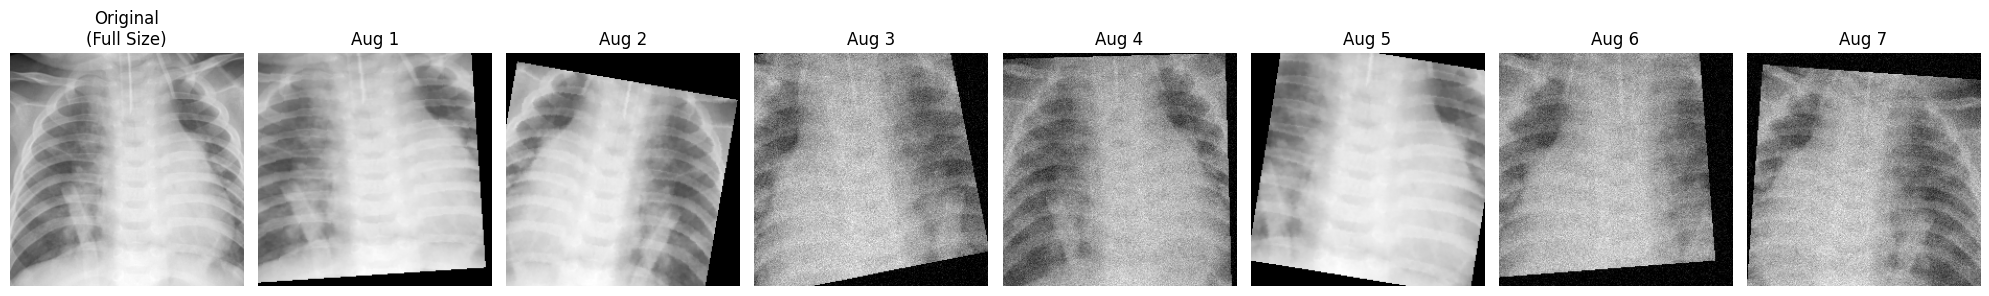

In [19]:
idx = np.random.randint(0, len(train_set))
img = train_set[idx]['pixel_values']
img = img.view(224, 224)

cxr_pipeline = get_cxr_transforms_v2()

visualize_series(img, cxr_pipeline, num_augs=7)

### Анализ

1. Удаляем Hue и Saturation и в целом ColorJitter
    - Рентген это одноканальное изображение. Изменение Hue или Saturation на черно-белом снимке либо ничего не делает, либо создает цветные артефакты, которых не бывает в реальности. Нам оно не надо для чернобелых снимков.

2. RandomResizedCrop scale=(0.08, 1.0) -> scale=(0.5, 1.0)
    - В ImageNet кроп 8% от картинки может все еще содежать какой-то сигнал. В рентгене кроп 8% это может быть пятно без контекста. По такому снимку ничего нельзя сказать, так это просто может быть текстура кости 2x2 см. Для постановки диагноза нужен почти полный контекст и нам не будет достаточно куска.

3. RandomAffine
    - В целом пациенты могут лежать криво. Поэтому небольшие повороты (до 15-20 градусов) и сдвиги могут научить модель инвариантности к небольшим изменениям.

4. RandomHorizontalFlip?

    - Для SSL: Оставляем. Учим что правое и левое легкое это одинаковые сущности, а разворот усиливает разнообразность в два раза.

    - Для классификации (SFT): Отключаем. У человека сердце слева. Если мы флипнем у нас сердце окажется справа а это уже будет совсем другая история.

5. GaussianBlur

    - Плохие аппараты могу легко выдать зернистые снимки, так что добавление гауссовского шума оставит нас в рамках возможной генеральной совопукности.

6. Инверсия

    - Не берем потому что у нас рентген это карта плотностей, а инверсия нам испортит связь с плотностями, чего никогда не произойдет в реальности.
